In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import shap

# Data Preprocessing
in oder to have data in good format I had to remove some lines from oryginal csv file

In [172]:
df_raw = pd.read_csv('monthly_in_situ_co2_mlo.csv')
df_raw

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
2,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44,MLO
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16,MLO
4,1958,5,21320,1958.3699,317.51,314.69,317.89,315.07,317.51,314.69,MLO
...,...,...,...,...,...,...,...,...,...,...,...
799,2024,8,45519,2024.6230,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
800,2024,9,45550,2024.7077,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
801,2024,10,45580,2024.7896,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
802,2024,11,45611,2024.8743,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [173]:
df = df_raw[['Yr', 'Mn', 'CO2']]
df

,Yr,Mn,CO2
0,1958,1,-99.99
1,1958,2,-99.99
2,1958,3,315.71
3,1958,4,317.45
4,1958,5,317.51
...,...,...,...
799,2024,8,-99.99
800,2024,9,-99.99
801,2024,10,-99.99
802,2024,11,-99.99


In [174]:
# connect Yr and Mn columns to a single date column
df['date'] = pd.to_datetime(df.Yr.astype(str) + '-' + df.Mn.astype(str), errors='coerce')
df = df.drop(columns=['Yr', 'Mn'])
df = df.set_index('date')
df

C:\Users\Ignacy\AppData\Local\Temp\ipykernel_2388\3795550059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.Yr.astype(str) + '-' + df.Mn.astype(str), errors='coerce')


,CO2
date,
1958-01-01,-99.99
1958-02-01,-99.99
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.51
...,...
2024-08-01,-99.99
2024-09-01,-99.99
2024-10-01,-99.99


In [175]:
# find -99.99 in CO2 column and replace it with NaN
df['CO2'] = df['CO2'].replace(-99.99, np.nan)


In [176]:
df.head()

,CO2
date,
1958-01-01,NaN
1958-02-01,NaN
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.51


In [177]:
df.tail(10)

,CO2
date,
2024-03-01,425.22
2024-04-01,NaN
2024-05-01,NaN
2024-06-01,NaN
2024-07-01,NaN
2024-08-01,NaN
2024-09-01,NaN
2024-10-01,NaN
2024-11-01,NaN


So we have 2 NaN in at the beginning and 9 in the end, lets remove them

In [178]:
# remove 2 first and 9 last records
df = df[2:-9]
df

,CO2
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,NaN
1958-07-01,315.87
...,...
2023-11-01,420.12
2023-12-01,421.65
2024-01-01,422.62


In [179]:
# count NaN values
df.isnull().sum()

CO2    5
dtype: int64

In [180]:
# fill NaN with backward fill
df.bfill(inplace=True)

C:\Users\Ignacy\AppData\Local\Temp\ipykernel_2388\1776350103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace=True)


<Axes: xlabel='date'>

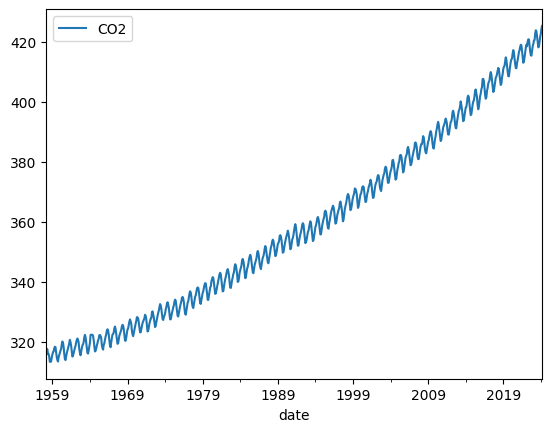

In [181]:
df.plot()

In [182]:
data = df.copy()

In [183]:
for i in range(12,0,-1):
  df['t='+str(i)] = df['CO2'].shift(i)
df.dropna(inplace=True)

C:\Users\Ignacy\AppData\Local\Temp\ipykernel_2388\940505050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t='+str(i)] = df['CO2'].shift(i)
C:\Users\Ignacy\AppData\Local\Temp\ipykernel_2388\940505050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t='+str(i)] = df['CO2'].shift(i)
C:\Users\Ignacy\AppData\Local\Temp\ipykernel_2388\940505050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [184]:
df

,CO2,t=12,t=11,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
date,,,,,,,,,,,,,
1959-03-01,316.65,315.71,317.45,317.51,315.87,315.87,314.93,313.21,313.33,313.33,314.67,315.58,316.49
1959-04-01,317.72,317.45,317.51,315.87,315.87,314.93,313.21,313.33,313.33,314.67,315.58,316.49,316.65
1959-05-01,318.29,317.51,315.87,315.87,314.93,313.21,313.33,313.33,314.67,315.58,316.49,316.65,317.72
1959-06-01,318.15,315.87,315.87,314.93,313.21,313.33,313.33,314.67,315.58,316.49,316.65,317.72,318.29
1959-07-01,316.54,315.87,314.93,313.21,313.33,313.33,314.67,315.58,316.49,316.65,317.72,318.29,318.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,420.12,417.03,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40
2023-12-01,421.65,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12
2024-01-01,422.62,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12,421.65


# Preparing train/test split

In [185]:
X = df.iloc[:,1:].values

In [186]:
y = df.iloc[:,0].values

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Time Series Forecasting

In [188]:
train = data[:-12]
test = data[-12:]

In [189]:
df_comp = test['CO2'].to_frame()

In [190]:
def get_first_eval_batch(data, n):
  return data[-n:].reshape(-1,n)

## Random Forest

In [191]:
rfr_grid = {'n_estimators': [50, 100, 200, 300, 400], 'max_features': [1, 2, 3, 4, 5, 6], 'random_state': [42]}
best_score = -float('inf')

best_model = None

for g in ParameterGrid(rfr_grid):
  model = RandomForestRegressor(**g)
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  if score > best_score:
    best_score = score
    best_model = model

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

print('Error for train data:')
print(mean_absolute_percentage_error(y_train, train_predict) * 100)
print('Error for test data:')
print(mean_absolute_percentage_error(y_test, test_predict) * 100)

Error for train data:
0.04980857846342123
Error for test data:
0.12819641475232904


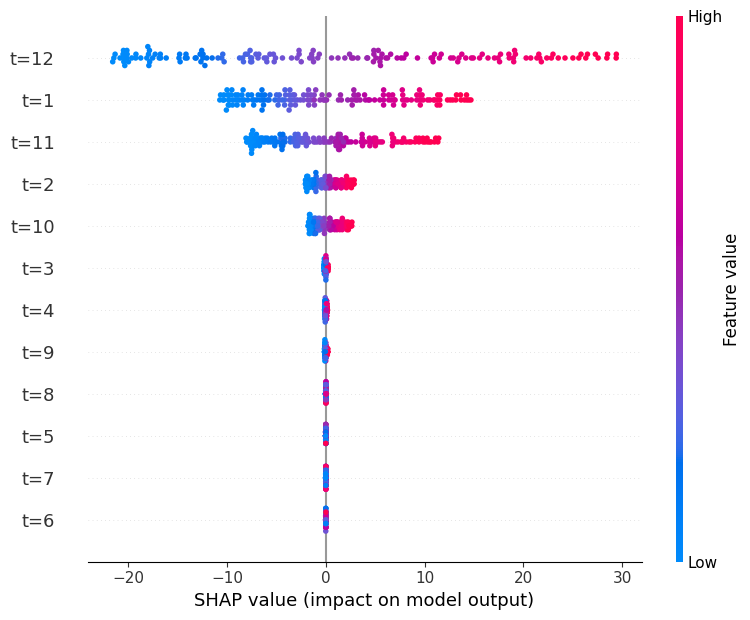

In [192]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:])


shap.summary_plot(shap_values, X_test, feature_names=df.columns.to_list()[1:], max_display=12)

In [193]:
n_lag = 12
test_pred = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
  current_pred = best_model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [194]:
df_comp['rfr'] = test_pred

## Gradient Boosting

In [195]:
gbr_grid = {
  'n_estimators': [50, 100, 200, 300, 400], 
  'max_features':  [1, 2, 3, 4, 5, 6], 
  'learning_rate': [0.01, 0.02, 0.03],
  'random_state': [42], 
  }
best_score = -float('inf')

best_model = None

for g in ParameterGrid(gbr_grid):
  model = GradientBoostingRegressor(**g)
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  if score > best_score:
    best_score = score
    best_model = model

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

print('Error for train data:')
print(mean_absolute_percentage_error(y_train, train_predict) * 100)
print('Error for test data:')
print(mean_absolute_percentage_error(y_test, test_predict) * 100)

Error for train data:
0.061939199874724515
Error for test data:
0.14903217665935461


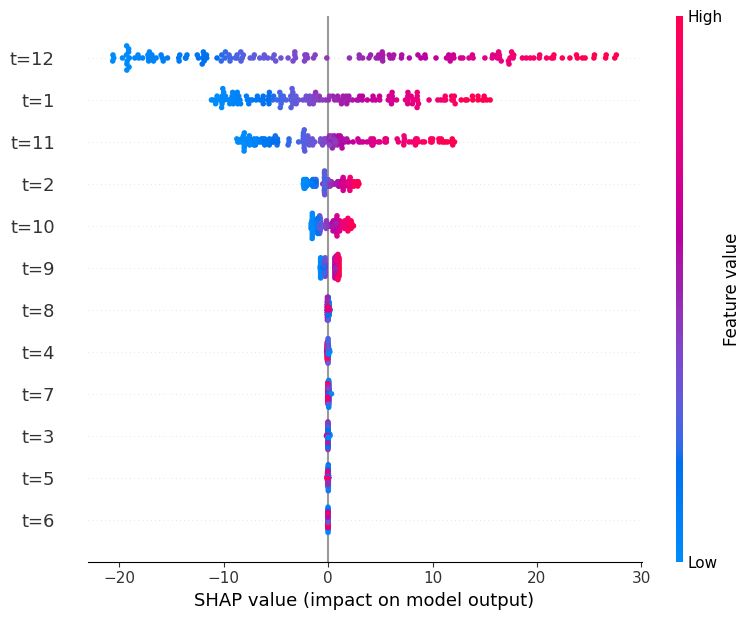

In [196]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:])


shap.summary_plot(shap_values, X_test, feature_names=df.columns.to_list()[1:], max_display=12)

In [197]:
n_lag = 12
test_pred = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
  current_pred = best_model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [198]:
df_comp['gbr'] = test_pred

## Extreme Gradient Boosting

In [199]:
xgbr_grid = {
  'n_estimators': [50, 100, 200, 300, 400], 
  'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
  'learning_rate': [0.01, 0.02, 0.03],
  'random_state': [42], 
  }
best_score = -float('inf')

best_model = None

for g in ParameterGrid(gbr_grid):
  model = XGBRegressor(**g)
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  if score > best_score:
    best_score = score
    best_model = model

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

print('Error for train data:')
print(mean_absolute_percentage_error(y_train, train_predict) * 100)
print('Error for test data:')
print(mean_absolute_percentage_error(y_test, test_predict) * 100)

c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:37:20] WARNING: C:\buildk

Error for train data:
0.03778780176683036
Error for test data:
0.136272396437696


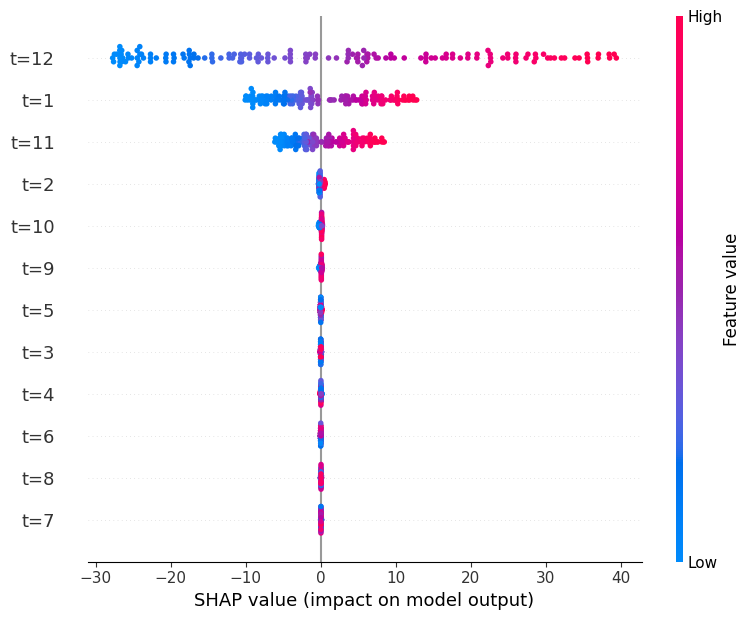

In [200]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:])


shap.summary_plot(shap_values, X_test, feature_names=df.columns.to_list()[1:], max_display=12)

In [201]:
n_lag = 12
test_pred = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
  current_pred = best_model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [202]:
df_comp['xgbr'] = test_pred

# Checking Arima

In [203]:
auto_arima(train, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=568.813, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2568.625, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1774.607, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2575.551, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1256.299, Time=1.26 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=910.407, Time=1.46 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=578.145, Time=3.55 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=620.199, Time=3.49 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1628.245, Time=0.33 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=721.623, Time=3.80 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=584.854, Time=4.23 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=566.974, Time=1.31 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  781
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -264.631
Date:                            Mon, 13 May 2024   AIC                            539.262
Time:                                    18:38:55   BIC                            562.558
Sample:                                03-01-1958   HQIC                           548.222
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3923      0.053      7.396      0.000       0.288       0.496
ma.L1         -0.7106      0.045    -15.872      0.000      -0.798      -0.623
ar.S.L12       0.9996      0.000   2718.162      0.000       0.999       1.000
ma.S.L12      -0.8670      0.021    -40.886      0.000      -0.909      -0.825
sigma2         0.1078      0.004     28.567      0.000       0.100       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               190.09
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.33
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [204]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12))
fit_SARIMAX = model.fit()
fit_SARIMAX.summary()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                CO2   No. Observations:                  781
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -264.631
Date:                            Mon, 13 May 2024   AIC                            539.262
Time:                                    18:38:56   BIC                            562.558
Sample:                                03-01-1958   HQIC                           548.222
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3923      0.053      7.396      0.000       0.288       0.496
ma.L1         -0.7106      0.045    -15.872      0.000      -0.798      -0.623
ar.S.L12       0.9996      0.000   2718.162      0.000       0.999       1.000
ma.S.L12      -0.8670      0.021    -40.886      0.000      -0.909      -0.825
sigma2         0.1078      0.004     28.567      0.000       0.100       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               190.09
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.33
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

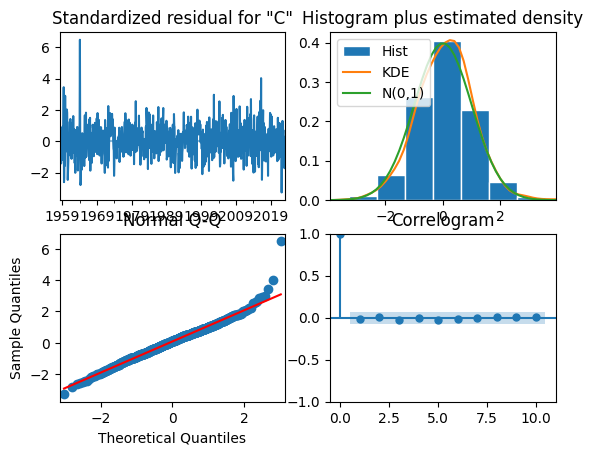

In [205]:
fit_SARIMAX.plot_diagnostics();

In [206]:
start = len(train)
end = len(train) + len(test) -1
prediction_SARIMA = fit_SARIMAX.predict(start, end).rename('SARIMA')

In [207]:
df_comp['SARIMA'] = prediction_SARIMA

# Models comparison

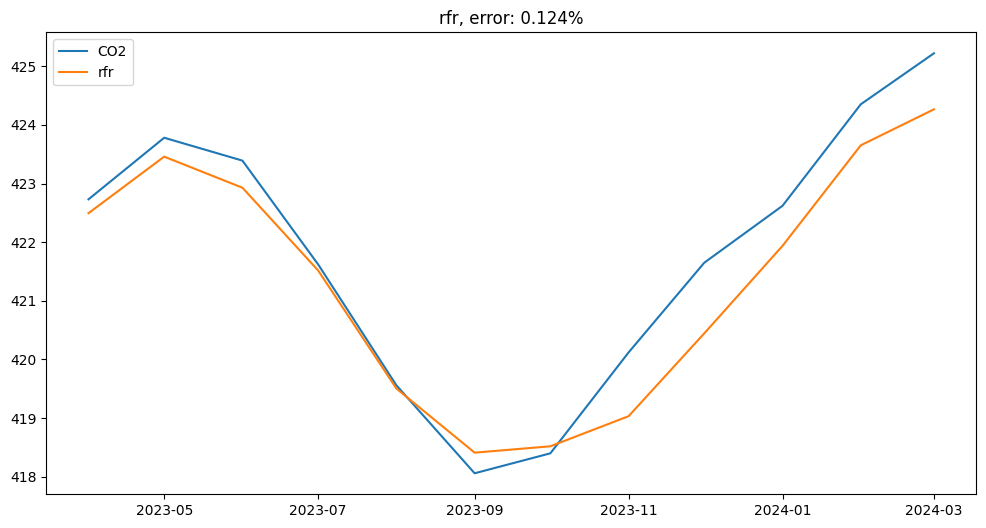

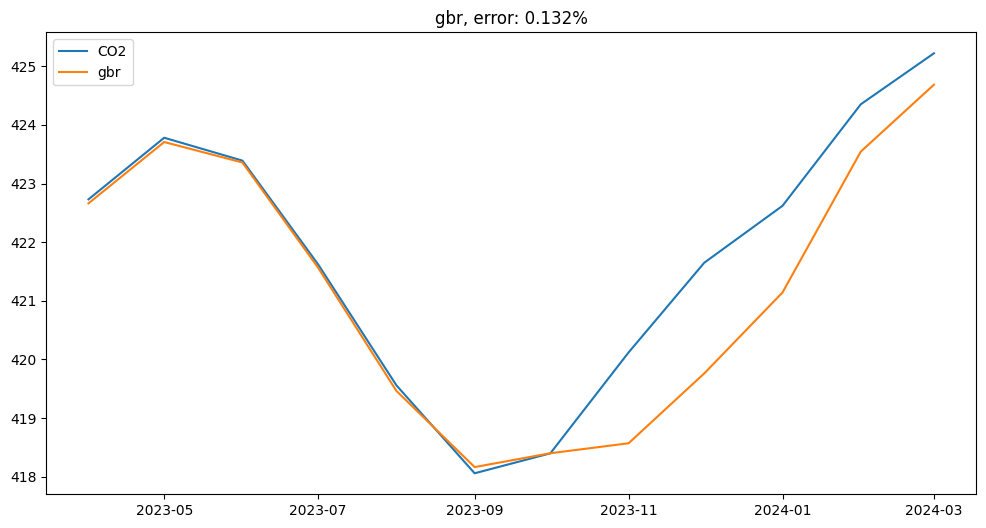

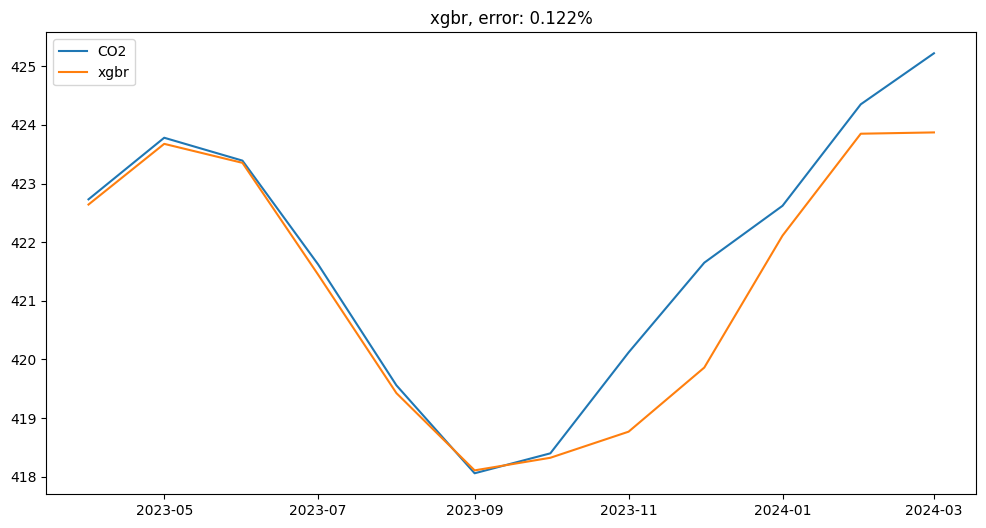

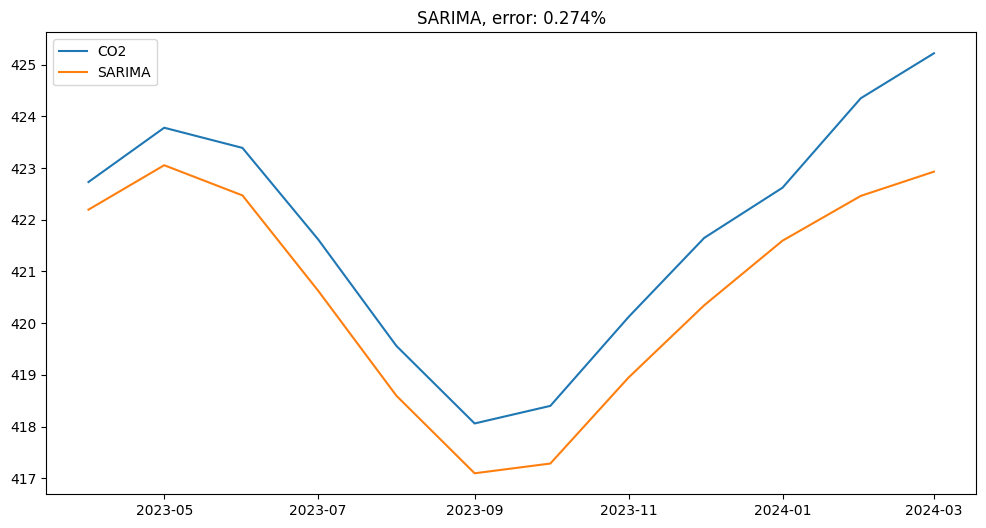

In [211]:
models_columns = ['rfr', 'gbr', 'xgbr', 'SARIMA']
for model in models_columns:
  plt.figure(figsize=(12, 6))
  plt.title(f'{model}, error: {mean_absolute_percentage_error(df_comp["CO2"], df_comp[model]) * 100:.3f}%')
  plt.plot(df_comp['CO2'], label='CO2')
  plt.plot(df_comp[model], label=model)
  plt.legend()
  plt.plot()

# Conclusions
The best model is XGBoost with MAPE 0.122%